In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置matplotlib使用中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 参数设置
MAX_FORCE = 200000  # 单个机械臂最大推力，单位：牛
MAX_LENGTH = 1.6  # 最大伸缩长度，单位：米
MAX_SPEED = 0.0001  # 最大伸缩速度，单位：米/秒
MAX_ANGLE = np.radians(30)  # 最大旋转角度，单位：弧度
CONTROL_FREQ = 30  # 控制频率，单位：Hz
SHIP_CG = (0, 0, 0)  # 船舶重心位置
ARM_POSITIONS = [(30, 10.25, 7.95), (-42, 10.25, 7.95)]  # 两个机械臂位置（船首、船尾）

# PID控制器参数
Kp_angle = 10  # 角度控制的比例增益
Ki_angle = 0.1  # 角度控制的积分增益
Kd_angle = 1  # 角度控制的微分增益

Kp_length = 10  # 长度控制的比例增益
Ki_length = 0.1  # 长度控制的积分增益
Kd_length = 1  # 长度控制的微分增益

# 权重系数
ARM_WEIGHTS = [0.7, 0.3]  # 船首、船尾机械臂的权重

# 船舶质量和初始速度
SHIP_MASS = 50000  # 船舶质量，单位：千克
initial_ship_velocity = np.array([0.0, 0.0], dtype=np.float64)  # 初始船舶速度
ship_position = np.array([0.0, 0.0], dtype=np.float64)  # 初始船舶位置，单位：米


class HydraulicArm:
    def __init__(self, position):
        self.position = np.array(position)  # 机械臂安装位置
        self.angle = 0  # 当前旋转角度，单位：弧度
        self.length = 0.8  # 初始长度，单位：米

        # PID的初始误差
        self.angle_integral = 0
        self.angle_prev_error = 0
        self.length_integral = 0
        self.length_prev_error = 0

    def control(self, target_force, target_angle):
        """
        PID控制器计算新的角度和伸缩长度。
        """
        # 计算目标长度
        target_length = min(MAX_LENGTH, abs(target_force) / MAX_FORCE * MAX_LENGTH)

        # 控制角度（PID）
        angle_error = target_angle - self.angle
        self.angle_integral += angle_error / CONTROL_FREQ  # 积分项
        angle_derivative = (angle_error - self.angle_prev_error) * CONTROL_FREQ  # 微分项

        # 限制微分项
        max_error_change = 10  # 误差变化的最大限制
        angle_derivative = np.clip(angle_derivative, -max_error_change, max_error_change)

        angle_control = Kp_angle * angle_error + Ki_angle * self.angle_integral + Kd_angle * angle_derivative

        # 更新角度，加入角度限制
        self.angle += angle_control
        self.angle = np.clip(self.angle, -MAX_ANGLE, MAX_ANGLE)
        self.angle_prev_error = angle_error

        # 控制长度（PID）
        length_error = target_length - self.length
        self.length_integral += length_error / CONTROL_FREQ  # 积分项
        length_derivative = (length_error - self.length_prev_error) * CONTROL_FREQ  # 微分项
        length_control = Kp_length * length_error + Ki_length * self.length_integral + Kd_length * length_derivative

        # 计算变化量并限制伸缩速度
        length_change = self.length + length_control - self.length
        max_length_change = MAX_SPEED * CONTROL_FREQ  # 计算最大允许的伸缩变化量
        length_change = np.clip(length_change, -max_length_change, max_length_change)

        # 更新机械臂长度
        self.length += length_change
        self.length = np.clip(self.length, -MAX_LENGTH, MAX_LENGTH)  # 允许伸缩为负值
        self.length_prev_error = length_error

        return self.angle, self.length


def ship_dynamics(external_force, ship_mass, velocity, dt):
    """
    模拟船舶的动力学反应，根据外部力计算船舶的速度和位置
    """
    acceleration = external_force / ship_mass  # 根据牛顿第二定律计算加速度
    velocity += acceleration * dt  # 速度更新
    position = velocity * dt  # 根据速度更新位置
    return position, velocity


def optimize_angles(force_direction, arm_positions):
    """
    根据目标力方向优化机械臂的旋转角度。
    """
    optimized_angles = []
    for position in arm_positions:
        relative_angle = np.arctan2(position[1], position[0])
        optimized_angle = force_direction - relative_angle
        optimized_angle = np.clip(optimized_angle, -MAX_ANGLE, MAX_ANGLE)
        optimized_angles.append(optimized_angle)
    return optimized_angles


def force_allocation(total_force, force_direction, arm_weights):
    """
    基于机械臂权重分配力，并可能允许反向力。
    """
    f1 = total_force * arm_weights[0]
    f2 = total_force * arm_weights[1]
    # 根据情况调整角度偏移，可能允许力在某些情况下反向作用
    a1 = force_direction + np.radians(10)
    a2 = force_direction - np.radians(10)
    return f1, a1, f2, a2


def plot_force_directions(times, total_force_directions, combined_force_directions, save_path):
    """
    绘制力的方向变化图。
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, np.degrees(total_force_directions), 'r-', label="外部力方向")
    ax.plot(times, np.degrees(combined_force_directions), 'b-', label="合成机械臂力方向")

    ax.set_title("力的方向随时间变化")
    ax.set_xlabel("时间 (s)")
    ax.set_ylabel("力的方向 (度)")
    ax.legend()

    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.savefig(os.path.join(save_path, "force_directions_over_time.png"))
    plt.close(fig)


def plot_arm_data(times, arm1_angles, arm1_lengths, arm1_forces, arm2_angles, arm2_lengths, arm2_forces, save_path):
    """
    绘制机械臂角度、伸缩长度和推力的变化。
    """
    # 绘制机械臂1角度、长度和推力变化
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    axs[0].plot(times, np.degrees(arm1_angles), label='机械臂1角度', color='r')
    axs[0].set_ylabel('角度 (度)')
    axs[0].set_title('机械臂1角度变化')

    axs[1].plot(times, arm1_lengths, label='机械臂1长度', color='g')
    axs[1].set_ylabel('长度 (米)')
    axs[1].set_title('机械臂1伸缩长度变化')

    axs[2].plot(times, arm1_forces, label='机械臂1推力', color='b')
    axs[2].set_ylabel('推力 (牛)')
    axs[2].set_title('机械臂1推力变化')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arm1_data.png"))
    plt.close(fig)

    # 绘制机械臂2角度、长度和推力变化
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    axs[0].plot(times, np.degrees(arm2_angles), label='机械臂2角度', color='r')
    axs[0].set_ylabel('角度 (度)')
    axs[0].set_title('机械臂2角度变化')

    axs[1].plot(times, arm2_lengths, label='机械臂2长度', color='g')
    axs[1].set_ylabel('长度 (米)')
    axs[1].set_title('机械臂2伸缩长度变化')

    axs[2].plot(times, arm2_forces, label='机械臂2推力', color='b')
    axs[2].set_ylabel('推力 (牛)')
    axs[2].set_title('机械臂2推力变化')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arm2_data.png"))
    plt.close(fig)

    # 绘制两个机械臂的推力对比图
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, arm1_forces, label='机械臂1推力', color='r')
    ax.plot(times, arm2_forces, label='机械臂2推力', color='b')
    ax.set_title('两个机械臂推力对比')
    ax.set_xlabel('时间 (s)')
    ax.set_ylabel('推力 (牛)')
    ax.legend()

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arms_force_comparison.png"))
    plt.close(fig)



def plot_ship_data(times, ship_positions, ship_speeds, save_path):
    """
    绘制船舶位置和速度变化。
    """
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel('时间 (s)')
    ax1.set_ylabel('位置 (米)', color='tab:red')
    ax1.plot(times, [pos[0] for pos in ship_positions], 'r-', label="船舶X位置")
    ax1.plot(times, [pos[1] for pos in ship_positions], 'g-', label="船舶Y位置")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('速度 (米/秒)', color='tab:blue')
    ax2.plot(times, ship_speeds, 'b-', label="船舶速度")
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "ship_data.png"))
    plt.close(fig)


def calculate_final_force(total_forces, combined_forces, total_force_directions, combined_force_directions):
    """
    计算最终的力（外部力和两个机械臂合力矢量相减后的力）。
    """
    final_forces = []
    final_force_directions = []

    for i in range(len(total_forces)):
        # 外部力和机械臂合力之间的差值
        force_diff = total_forces[i] - combined_forces[i]
        final_forces.append(force_diff)

        # 计算方向差
        external_angle = total_force_directions[i]
        combined_angle = combined_force_directions[i]

        # 计算方向差（可以通过简单的角度差来计算）
        direction_diff = external_angle - combined_angle
        final_force_directions.append(direction_diff)

    return final_forces, final_force_directions


def plot_final_forces(times, final_forces, final_force_directions, save_path):
    """
    绘制船舶所受的最终力的大小和方向随时间变化。
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))

    # 绘制最终力的大小
    ax[0].plot(times, final_forces, 'b-', label="最终力大小")
    ax[0].set_title("船舶所受最终力的大小随时间变化")
    ax[0].set_xlabel("时间 (s)")
    ax[0].set_ylabel("力的大小 (牛)")
    ax[0].legend()

    # 绘制最终力的方向
    ax[1].plot(times, np.degrees(final_force_directions), 'r-', label="最终力方向")
    ax[1].set_title("船舶所受最终力的方向随时间变化")
    ax[1].set_xlabel("时间 (s)")
    ax[1].set_ylabel("力的方向 (度)")
    ax[1].legend()

    # 保存图像
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "final_forces_over_time.png"))
    plt.close(fig)

def plot_combined_and_external_forces(times, total_forces, combined_forces, total_force_directions, combined_force_directions, save_path):
    """
    绘制两个机械臂的合力与外部输入力的大小和方向的变化。
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))

    # 绘制外部输入力和合力的大小变化
    ax[0].plot(times, total_forces, 'r-', label="外部输入力大小")
    ax[0].plot(times, combined_forces, 'b-', label="机械臂合力大小")
    ax[0].set_title("外部输入力与机械臂合力大小随时间变化")
    ax[0].set_xlabel("时间 (s)")
    ax[0].set_ylabel("力的大小 (牛)")
    ax[0].legend()

    # 绘制外部输入力和合力的方向变化
    ax[1].plot(times, np.degrees(total_force_directions), 'r-', label="外部输入力方向")
    ax[1].plot(times, np.degrees(combined_force_directions), 'b-', label="机械臂合力方向")
    ax[1].set_title("外部输入力与机械臂合力方向随时间变化")
    ax[1].set_xlabel("时间 (s)")
    ax[1].set_ylabel("力的方向 (度)")
    ax[1].legend()

    # 保存图像
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "combined_and_external_forces.png"))
    plt.close(fig)

def plot_ship_trajectory(ship_positions, save_path):
    """
    绘制船舶的运动轨迹。
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    positions_x = [pos[0] for pos in ship_positions]
    positions_y = [pos[1] for pos in ship_positions]

    ax.plot(positions_x, positions_y, label="船舶轨迹", color='b')
    ax.set_title("船舶运动轨迹")
    ax.set_xlabel("X 位置 (米)")
    ax.set_ylabel("Y 位置 (米)")
    ax.legend()

    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "ship_trajectory.png"))
    plt.close(fig)


def main_control_loop(max_force, frequency, duration, save_path):
    """
    主控制循环，分配力并生成多个静态图。
    """
    arm1 = HydraulicArm(ARM_POSITIONS[0])
    arm2 = HydraulicArm(ARM_POSITIONS[1])

    dt = 1 / CONTROL_FREQ
    times = np.arange(0, duration, dt)
    total_forces = max_force * np.sin(2 * np.pi * frequency * times)
    directions = np.radians(85) + np.radians(10 * np.sin(0.1 * times))

    # 数据存储
    arm1_angles, arm1_lengths = [], []
    arm2_angles, arm2_lengths = [], []
    arm1_forces, arm2_forces = [], []
    total_force_directions = []
    combined_forces = []  # 存储合力大小
    combined_force_directions = []  # 存储合力方向
    final_forces = []  # 存储最终力的大小
    final_force_directions = []  # 存储最终力的方向

    # 船舶速度和位置
    ship_velocity = np.array([0.0, 0.0], dtype=np.float64)
    ship_position = np.array([0.0, 0.0], dtype=np.float64)

    # 存储船舶位置和速度
    ship_positions = []
    ship_speeds = []

    for i, t in enumerate(times):
        # 获取当前目标力和方向
        total_force = total_forces[i]
        force_direction = directions[i]

        # 优化机械臂角度
        optimized_angles = optimize_angles(force_direction, ARM_POSITIONS)

        # 分配力
        f1, a1, f2, a2 = force_allocation(total_force, force_direction, ARM_WEIGHTS)

        # 控制机械臂
        angle1, length1 = arm1.control(f1, optimized_angles[0])
        angle2, length2 = arm2.control(f2, optimized_angles[1])

        # 记录数据
        arm1_angles.append(angle1)
        arm1_lengths.append(length1)
        arm1_forces.append(f1)
        arm2_angles.append(angle2)
        arm2_lengths.append(length2)
        arm2_forces.append(f2)
        total_force_directions.append(force_direction)

        # 初始化变量记录单独力的正负
        f1_sign = 1 if f1 > 0 else -1  # 记录f1的正负
        f2_sign = 1 if f2 > 0 else -1  # 记录f2的正负

        # 计算每个力的分量
        f1_x = f1 * np.cos(a1)
        f1_y = f1 * np.sin(a1)
        f2_x = f2 * np.cos(a2)
        f2_y = f2 * np.sin(a2)

        # 计算总合力的分量
        combined_force_x = f1_x + f2_x
        combined_force_y = f1_y + f2_y

        # 合力的大小（标量总是正值）
        combined_force_magnitude = np.sqrt(combined_force_x ** 2 + combined_force_y ** 2)

        # 合力的方向
        combined_direction = np.arctan2(combined_force_y, combined_force_x)

        # 根据单独力的方向判定合力的正负
        if f1_sign == f2_sign:  # 如果两个力方向一致，合力方向也一致
            combined_force = combined_force_magnitude * f1_sign
        else:  # 如果方向不一致，根据实际计算结果决定符号
            combined_force = combined_force_magnitude * (1 if combined_force_x >= 0 else -1)

        # 记录合力大小和方向
        combined_forces.append(combined_force)
        combined_force_directions.append(combined_direction)

        # 计算最终力
        final_force = total_force - combined_force
        final_force_direction = force_direction - combined_direction
        final_forces.append(final_force)
        final_force_directions.append(final_force_direction)

        # 船舶动力学更新
        ship_position, ship_velocity = ship_dynamics(final_force, SHIP_MASS, ship_velocity, dt)
        ship_positions.append(ship_position)
        ship_speeds.append(np.linalg.norm(ship_velocity))

    # 绘制机械臂数据
    plot_arm_data(times, arm1_angles, arm1_lengths, arm1_forces, arm2_angles, arm2_lengths, arm2_forces, save_path)
    # 绘制力的方向
    plot_force_directions(times, total_force_directions, combined_force_directions, save_path)
    # 绘制船舶所受的最终力
    plot_final_forces(times, final_forces, final_force_directions, save_path)
    # 绘制外部输入力与机械臂合力
    plot_combined_and_external_forces(times, total_forces, combined_forces, total_force_directions, combined_force_directions, save_path)
    # 绘制船舶数据
    plot_ship_data(times, ship_positions, ship_speeds, save_path)
    # 绘制船舶运动轨迹
    plot_ship_trajectory(ship_positions, save_path)


    # 返回最终的力数据和船舶数据
    return final_forces, final_force_directions, ship_positions, ship_speeds





# 设置保存路径并运行主控制循环
save_path = "C:/Users/assus/Desktop/机械臂控制/PID"
final_forces, final_force_directions, ship_positions, ship_speeds = main_control_loop(MAX_FORCE, 0.5, 5, save_path)

print("模拟完成，结果已保存。")

模拟完成，结果已保存。


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置matplotlib使用中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 参数设置
MAX_FORCE = 200000  # 单个机械臂最大推力，单位：牛
MAX_LENGTH = 1.6  # 最大伸缩长度，单位：米
MAX_SPEED = 0.0001  # 最大伸缩速度，单位：米/秒
MAX_ANGLE = np.radians(30)  # 最大旋转角度，单位：弧度
CONTROL_FREQ = 30  # 控制频率，单位：Hz
SHIP_CG = (0, 0, 0)  # 船舶重心位置
ARM_POSITIONS = [(30, 10.25, 7.95), (-42, 10.25, 7.95)]  # 两个机械臂位置（船首、船尾）


# 权重系数
ARM_WEIGHTS = [0.7, 0.3]  # 船首、船尾机械臂的权重

# 船舶质量和初始速度
SHIP_MASS = 50000  # 船舶质量，单位：千克
initial_ship_velocity = np.array([0.0, 0.0], dtype=np.float64)  # 初始船舶速度
ship_position = np.array([0.0, 0.0], dtype=np.float64)  # 初始船舶位置，单位：米


# 滑模控制器参数
K_angle = 20  # 角度控制的增益
K_length = 20  # 长度控制的增益

class HydraulicArm:
    def __init__(self, position):
        self.position = np.array(position)  # 机械臂安装位置
        self.angle = 0  # 当前旋转角度，单位：弧度
        self.length = 0.8  # 初始长度，单位：米

    def control(self, target_force, target_angle):
        """
        滑模控制器计算新的角度和伸缩长度。
        """
        # 计算目标长度
        target_length = min(MAX_LENGTH, abs(target_force) / MAX_FORCE * MAX_LENGTH)

        # 控制角度（滑模控制）
        angle_error = target_angle - self.angle
        angle_control = -K_angle * np.sign(angle_error)

        # 更新角度，加入角度限制
        self.angle += angle_control
        self.angle = np.clip(self.angle, -MAX_ANGLE, MAX_ANGLE)

        # 控制长度（滑模控制）
        length_error = target_length - self.length
        length_control = -K_length * np.sign(length_error)

        # 计算变化量并限制伸缩速度
        length_change = self.length + length_control - self.length
        max_length_change = MAX_SPEED * CONTROL_FREQ  # 计算最大允许的伸缩变化量
        length_change = np.clip(length_change, -max_length_change, max_length_change)

        # 更新机械臂长度
        self.length += length_change
        self.length = np.clip(self.length, -MAX_LENGTH, MAX_LENGTH)  # 允许伸缩为负值

        return self.angle, self.length


def ship_dynamics(external_force, ship_mass, velocity, dt):
    """
    模拟船舶的动力学反应，根据外部力计算船舶的速度和位置
    """
    acceleration = external_force / ship_mass  # 根据牛顿第二定律计算加速度
    velocity += acceleration * dt  # 速度更新
    position = velocity * dt  # 根据速度更新位置
    return position, velocity


def optimize_angles(force_direction, arm_positions):
    """
    根据目标力方向优化机械臂的旋转角度。
    """
    optimized_angles = []
    for position in arm_positions:
        relative_angle = np.arctan2(position[1], position[0])
        optimized_angle = force_direction - relative_angle
        optimized_angle = np.clip(optimized_angle, -MAX_ANGLE, MAX_ANGLE)
        optimized_angles.append(optimized_angle)
    return optimized_angles


def force_allocation(total_force, force_direction, arm_weights):
    """
    基于机械臂权重分配力，并可能允许反向力。
    """
    f1 = total_force * arm_weights[0]
    f2 = total_force * arm_weights[1]
    # 根据情况调整角度偏移，可能允许力在某些情况下反向作用
    a1 = force_direction + np.radians(10)
    a2 = force_direction - np.radians(10)
    return f1, a1, f2, a2


def plot_force_directions(times, total_force_directions, combined_force_directions, save_path):
    """
    绘制力的方向变化图。
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, np.degrees(total_force_directions), 'r-', label="外部力方向")
    ax.plot(times, np.degrees(combined_force_directions), 'b-', label="合成机械臂力方向")

    ax.set_title("力的方向随时间变化")
    ax.set_xlabel("时间 (s)")
    ax.set_ylabel("力的方向 (度)")
    ax.legend()

    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.savefig(os.path.join(save_path, "force_directions_over_time.png"))
    plt.close(fig)


def plot_arm_data(times, arm1_angles, arm1_lengths, arm1_forces, arm2_angles, arm2_lengths, arm2_forces, save_path):
    """
    绘制机械臂角度、伸缩长度和推力的变化。
    """
    # 绘制机械臂1角度、长度和推力变化
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    axs[0].plot(times, np.degrees(arm1_angles), label='机械臂1角度', color='r')
    axs[0].set_ylabel('角度 (度)')
    axs[0].set_title('机械臂1角度变化')

    axs[1].plot(times, arm1_lengths, label='机械臂1长度', color='g')
    axs[1].set_ylabel('长度 (米)')
    axs[1].set_title('机械臂1伸缩长度变化')

    axs[2].plot(times, arm1_forces, label='机械臂1推力', color='b')
    axs[2].set_ylabel('推力 (牛)')
    axs[2].set_title('机械臂1推力变化')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arm1_data.png"))
    plt.close(fig)

    # 绘制机械臂2角度、长度和推力变化
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    axs[0].plot(times, np.degrees(arm2_angles), label='机械臂2角度', color='r')
    axs[0].set_ylabel('角度 (度)')
    axs[0].set_title('机械臂2角度变化')

    axs[1].plot(times, arm2_lengths, label='机械臂2长度', color='g')
    axs[1].set_ylabel('长度 (米)')
    axs[1].set_title('机械臂2伸缩长度变化')

    axs[2].plot(times, arm2_forces, label='机械臂2推力', color='b')
    axs[2].set_ylabel('推力 (牛)')
    axs[2].set_title('机械臂2推力变化')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arm2_data.png"))
    plt.close(fig)

    # 绘制两个机械臂的推力对比图
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, arm1_forces, label='机械臂1推力', color='r')
    ax.plot(times, arm2_forces, label='机械臂2推力', color='b')
    ax.set_title('两个机械臂推力对比')
    ax.set_xlabel('时间 (s)')
    ax.set_ylabel('推力 (牛)')
    ax.legend()

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arms_force_comparison.png"))
    plt.close(fig)



def plot_ship_data(times, ship_positions, ship_speeds, save_path):
    """
    绘制船舶位置和速度变化。
    """
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel('时间 (s)')
    ax1.set_ylabel('位置 (米)', color='tab:red')
    ax1.plot(times, [pos[0] for pos in ship_positions], 'r-', label="船舶X位置")
    ax1.plot(times, [pos[1] for pos in ship_positions], 'g-', label="船舶Y位置")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('速度 (米/秒)', color='tab:blue')
    ax2.plot(times, ship_speeds, 'b-', label="船舶速度")
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "ship_data.png"))
    plt.close(fig)


def calculate_final_force(total_forces, combined_forces, total_force_directions, combined_force_directions):
    """
    计算最终的力（外部力和两个机械臂合力矢量相减后的力）。
    """
    final_forces = []
    final_force_directions = []

    for i in range(len(total_forces)):
        # 外部力和机械臂合力之间的差值
        force_diff = total_forces[i] - combined_forces[i]
        final_forces.append(force_diff)

        # 计算方向差
        external_angle = total_force_directions[i]
        combined_angle = combined_force_directions[i]

        # 计算方向差（可以通过简单的角度差来计算）
        direction_diff = external_angle - combined_angle
        final_force_directions.append(direction_diff)

    return final_forces, final_force_directions


def plot_final_forces(times, final_forces, final_force_directions, save_path):
    """
    绘制船舶所受的最终力的大小和方向随时间变化。
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))

    # 绘制最终力的大小
    ax[0].plot(times, final_forces, 'b-', label="最终力大小")
    ax[0].set_title("船舶所受最终力的大小随时间变化")
    ax[0].set_xlabel("时间 (s)")
    ax[0].set_ylabel("力的大小 (牛)")
    ax[0].legend()

    # 绘制最终力的方向
    ax[1].plot(times, np.degrees(final_force_directions), 'r-', label="最终力方向")
    ax[1].set_title("船舶所受最终力的方向随时间变化")
    ax[1].set_xlabel("时间 (s)")
    ax[1].set_ylabel("力的方向 (度)")
    ax[1].legend()

    # 保存图像
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "final_forces_over_time.png"))
    plt.close(fig)

def plot_combined_and_external_forces(times, total_forces, combined_forces, total_force_directions, combined_force_directions, save_path):
    """
    绘制两个机械臂的合力与外部输入力的大小和方向的变化。
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))

    # 绘制外部输入力和合力的大小变化
    ax[0].plot(times, total_forces, 'r-', label="外部输入力大小")
    ax[0].plot(times, combined_forces, 'b-', label="机械臂合力大小")
    ax[0].set_title("外部输入力与机械臂合力大小随时间变化")
    ax[0].set_xlabel("时间 (s)")
    ax[0].set_ylabel("力的大小 (牛)")
    ax[0].legend()

    # 绘制外部输入力和合力的方向变化
    ax[1].plot(times, np.degrees(total_force_directions), 'r-', label="外部输入力方向")
    ax[1].plot(times, np.degrees(combined_force_directions), 'b-', label="机械臂合力方向")
    ax[1].set_title("外部输入力与机械臂合力方向随时间变化")
    ax[1].set_xlabel("时间 (s)")
    ax[1].set_ylabel("力的方向 (度)")
    ax[1].legend()

    # 保存图像
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "combined_and_external_forces.png"))
    plt.close(fig)

def plot_ship_trajectory(ship_positions, save_path):
    """
    绘制船舶的运动轨迹。
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    positions_x = [pos[0] for pos in ship_positions]
    positions_y = [pos[1] for pos in ship_positions]

    ax.plot(positions_x, positions_y, label="船舶轨迹", color='b')
    ax.set_title("船舶运动轨迹")
    ax.set_xlabel("X 位置 (米)")
    ax.set_ylabel("Y 位置 (米)")
    ax.legend()

    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "ship_trajectory.png"))
    plt.close(fig)


def main_control_loop(max_force, frequency, duration, save_path):
    """
    主控制循环，分配力并生成多个静态图。
    """
    arm1 = HydraulicArm(ARM_POSITIONS[0])
    arm2 = HydraulicArm(ARM_POSITIONS[1])

    dt = 1 / CONTROL_FREQ
    times = np.arange(0, duration, dt)
    total_forces = max_force * np.sin(2 * np.pi * frequency * times)
    directions = np.radians(85) + np.radians(10 * np.sin(0.1 * times))

    # 数据存储
    arm1_angles, arm1_lengths = [], []
    arm2_angles, arm2_lengths = [], []
    arm1_forces, arm2_forces = [], []
    total_force_directions = []
    combined_forces = []  # 存储合力大小
    combined_force_directions = []  # 存储合力方向
    final_forces = []  # 存储最终力的大小
    final_force_directions = []  # 存储最终力的方向

    # 船舶速度和位置
    ship_velocity = np.array([0.0, 0.0], dtype=np.float64)
    ship_position = np.array([0.0, 0.0], dtype=np.float64)

    # 存储船舶位置和速度
    ship_positions = []
    ship_speeds = []

    for i, t in enumerate(times):
        # 获取当前目标力和方向
        total_force = total_forces[i]
        force_direction = directions[i]

        # 优化机械臂角度
        optimized_angles = optimize_angles(force_direction, ARM_POSITIONS)

        # 分配力
        f1, a1, f2, a2 = force_allocation(total_force, force_direction, ARM_WEIGHTS)

        # 控制机械臂
        angle1, length1 = arm1.control(f1, optimized_angles[0])
        angle2, length2 = arm2.control(f2, optimized_angles[1])

        # 记录数据
        arm1_angles.append(angle1)
        arm1_lengths.append(length1)
        arm1_forces.append(f1)
        arm2_angles.append(angle2)
        arm2_lengths.append(length2)
        arm2_forces.append(f2)
        total_force_directions.append(force_direction)

        # 初始化变量记录单独力的正负
        f1_sign = 1 if f1 > 0 else -1  # 记录f1的正负
        f2_sign = 1 if f2 > 0 else -1  # 记录f2的正负

        # 计算每个力的分量
        f1_x = f1 * np.cos(a1)
        f1_y = f1 * np.sin(a1)
        f2_x = f2 * np.cos(a2)
        f2_y = f2 * np.sin(a2)

        # 计算总合力的分量
        combined_force_x = f1_x + f2_x
        combined_force_y = f1_y + f2_y

        # 合力的大小（标量总是正值）
        combined_force_magnitude = np.sqrt(combined_force_x ** 2 + combined_force_y ** 2)

        # 合力的方向
        combined_direction = np.arctan2(combined_force_y, combined_force_x)

        # 根据单独力的方向判定合力的正负
        if f1_sign == f2_sign:  # 如果两个力方向一致，合力方向也一致
            combined_force = combined_force_magnitude * f1_sign
        else:  # 如果方向不一致，根据实际计算结果决定符号
            combined_force = combined_force_magnitude * (1 if combined_force_x >= 0 else -1)

        # 记录合力大小和方向
        combined_forces.append(combined_force)
        combined_force_directions.append(combined_direction)

        # 计算最终力
        final_force = total_force - combined_force
        final_force_direction = force_direction - combined_direction
        final_forces.append(final_force)
        final_force_directions.append(final_force_direction)

        # 船舶动力学更新
        ship_position, ship_velocity = ship_dynamics(final_force, SHIP_MASS, ship_velocity, dt)
        ship_positions.append(ship_position)
        ship_speeds.append(np.linalg.norm(ship_velocity))

    # 绘制机械臂数据
    plot_arm_data(times, arm1_angles, arm1_lengths, arm1_forces, arm2_angles, arm2_lengths, arm2_forces, save_path)
    # 绘制力的方向
    plot_force_directions(times, total_force_directions, combined_force_directions, save_path)
    # 绘制船舶所受的最终力
    plot_final_forces(times, final_forces, final_force_directions, save_path)
    # 绘制外部输入力与机械臂合力
    plot_combined_and_external_forces(times, total_forces, combined_forces, total_force_directions, combined_force_directions, save_path)
    # 绘制船舶数据
    plot_ship_data(times, ship_positions, ship_speeds, save_path)
    # 绘制船舶运动轨迹
    plot_ship_trajectory(ship_positions, save_path)


    # 返回最终的力数据和船舶数据
    return final_forces, final_force_directions, ship_positions, ship_speeds





# 设置保存路径并运行主控制循环
save_path = "C:/Users/assus/Desktop/机械臂控制/滑模"
final_forces, final_force_directions, ship_positions, ship_speeds = main_control_loop(MAX_FORCE, 0.5, 15, save_path)

print("模拟完成，结果已保存。")

模拟完成，结果已保存。


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置matplotlib使用中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 参数设置
MAX_FORCE = 200000  # 单个机械臂最大推力，单位：牛
MAX_LENGTH = 1.6  # 最大伸缩长度，单位：米
MAX_SPEED = 0.0001  # 最大伸缩速度，单位：米/秒
MAX_ANGLE = np.radians(30)  # 最大旋转角度，单位：弧度
CONTROL_FREQ = 30  # 控制频率，单位：Hz
SHIP_CG = (0, 0, 0)  # 船舶重心位置
ARM_POSITIONS = [(30, 10.25, 7.95), (-42, 10.25, 7.95)]  # 两个机械臂位置（船首、船尾）


# 权重系数
ARM_WEIGHTS = [0.7, 0.3]  # 船首、船尾机械臂的权重

# 船舶质量和初始速度
SHIP_MASS = 50000  # 船舶质量，单位：千克
initial_ship_velocity = np.array([0.0, 0.0], dtype=np.float64)  # 初始船舶速度
ship_position = np.array([0.0, 0.0], dtype=np.float64)  # 初始船舶位置，单位：米


# 滑模控制器参数
K_angle = 20  # 角度控制的增益
K_length = 20  # 长度控制的增益

class HydraulicArm:
    def __init__(self, position):
        self.position = np.array(position)  # 机械臂安装位置
        self.angle = 0  # 当前旋转角度，单位：弧度
        self.length = 0.8  # 初始长度，单位：米
        # FTSMC参数
        self.p = 0.9
        self.q = 1.1
        self.K_angle = 10
        self.K_length = 10

    def finite_time_terminal_sliding_mode(self, error, gain):
        """
        有限时间终端滑模控制的控制律。
        error: 当前误差
        gain: 控制增益
        """
        s = np.sign(error) * (np.abs(error) ** self.p) - self.q * error
        control = -gain * s
        return control

    def control(self, target_force, target_angle):
        """
        有限时间终端滑模控制器计算新的角度和伸缩长度。
        """
        # 计算目标长度
        target_length = min(MAX_LENGTH, abs(target_force) / MAX_FORCE * MAX_LENGTH)

        # 控制角度（FTSMC）
        angle_error = target_angle - self.angle
        angle_control = self.finite_time_terminal_sliding_mode(angle_error, self.K_angle)

        # 更新角度，加入角度限制
        self.angle += angle_control
        self.angle = np.clip(self.angle, -MAX_ANGLE, MAX_ANGLE)

        # 控制长度（FTSMC）
        length_error = target_length - self.length
        length_control = self.finite_time_terminal_sliding_mode(length_error, self.K_length)

        # 计算变化量并限制伸缩速度
        length_change = self.length + length_control - self.length
        max_length_change = MAX_SPEED * CONTROL_FREQ  # 计算最大允许的伸缩变化量
        length_change = np.clip(length_change, -max_length_change, max_length_change)

        # 更新机械臂长度
        self.length += length_change
        self.length = np.clip(self.length, 0, MAX_LENGTH)

        return self.angle, self.length



def ship_dynamics(external_force, ship_mass, velocity, dt):
    """
    模拟船舶的动力学反应，根据外部力计算船舶的速度和位置
    """
    acceleration = external_force / ship_mass  # 根据牛顿第二定律计算加速度
    velocity += acceleration * dt  # 速度更新
    position = velocity * dt  # 根据速度更新位置
    return position, velocity


def optimize_angles(force_direction, arm_positions):
    """
    根据目标力方向优化机械臂的旋转角度。
    """
    optimized_angles = []
    for position in arm_positions:
        relative_angle = np.arctan2(position[1], position[0])
        optimized_angle = force_direction - relative_angle
        optimized_angle = np.clip(optimized_angle, -MAX_ANGLE, MAX_ANGLE)
        optimized_angles.append(optimized_angle)
    return optimized_angles


def force_allocation(total_force, force_direction, arm_weights):
    """
    基于机械臂权重分配力，并可能允许反向力。
    """
    f1 = total_force * arm_weights[0]
    f2 = total_force * arm_weights[1]
    # 根据情况调整角度偏移，可能允许力在某些情况下反向作用
    a1 = force_direction + np.radians(10)
    a2 = force_direction - np.radians(10)
    return f1, a1, f2, a2


def plot_force_directions(times, total_force_directions, combined_force_directions, save_path):
    """
    绘制力的方向变化图。
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, np.degrees(total_force_directions), 'r-', label="外部力方向")
    ax.plot(times, np.degrees(combined_force_directions), 'b-', label="合成机械臂力方向")

    ax.set_title("力的方向随时间变化")
    ax.set_xlabel("时间 (s)")
    ax.set_ylabel("力的方向 (度)")
    ax.legend()

    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.savefig(os.path.join(save_path, "force_directions_over_time.png"))
    plt.close(fig)


def plot_arm_data(times, arm1_angles, arm1_lengths, arm1_forces, arm2_angles, arm2_lengths, arm2_forces, save_path):
    """
    绘制机械臂角度、伸缩长度和推力的变化。
    """
    # 绘制机械臂1角度、长度和推力变化
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    axs[0].plot(times, np.degrees(arm1_angles), label='机械臂1角度', color='r')
    axs[0].set_ylabel('角度 (度)')
    axs[0].set_title('机械臂1角度变化')

    axs[1].plot(times, arm1_lengths, label='机械臂1长度', color='g')
    axs[1].set_ylabel('长度 (米)')
    axs[1].set_title('机械臂1伸缩长度变化')

    axs[2].plot(times, arm1_forces, label='机械臂1推力', color='b')
    axs[2].set_ylabel('推力 (牛)')
    axs[2].set_title('机械臂1推力变化')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arm1_data.png"))
    plt.close(fig)

    # 绘制机械臂2角度、长度和推力变化
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    axs[0].plot(times, np.degrees(arm2_angles), label='机械臂2角度', color='r')
    axs[0].set_ylabel('角度 (度)')
    axs[0].set_title('机械臂2角度变化')

    axs[1].plot(times, arm2_lengths, label='机械臂2长度', color='g')
    axs[1].set_ylabel('长度 (米)')
    axs[1].set_title('机械臂2伸缩长度变化')

    axs[2].plot(times, arm2_forces, label='机械臂2推力', color='b')
    axs[2].set_ylabel('推力 (牛)')
    axs[2].set_title('机械臂2推力变化')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arm2_data.png"))
    plt.close(fig)

    # 绘制两个机械臂的推力对比图
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(times, arm1_forces, label='机械臂1推力', color='r')
    ax.plot(times, arm2_forces, label='机械臂2推力', color='b')
    ax.set_title('两个机械臂推力对比')
    ax.set_xlabel('时间 (s)')
    ax.set_ylabel('推力 (牛)')
    ax.legend()

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "arms_force_comparison.png"))
    plt.close(fig)



def plot_ship_data(times, ship_positions, ship_speeds, save_path):
    """
    绘制船舶位置和速度变化。
    """
    fig, ax1 = plt.subplots(figsize=(8, 6))

    ax1.set_xlabel('时间 (s)')
    ax1.set_ylabel('位置 (米)', color='tab:red')
    ax1.plot(times, [pos[0] for pos in ship_positions], 'r-', label="船舶X位置")
    ax1.plot(times, [pos[1] for pos in ship_positions], 'g-', label="船舶Y位置")
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('速度 (米/秒)', color='tab:blue')
    ax2.plot(times, ship_speeds, 'b-', label="船舶速度")
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "ship_data.png"))
    plt.close(fig)


def calculate_final_force(total_forces, combined_forces, total_force_directions, combined_force_directions):
    """
    计算最终的力（外部力和两个机械臂合力矢量相减后的力）。
    """
    final_forces = []
    final_force_directions = []

    for i in range(len(total_forces)):
        # 外部力和机械臂合力之间的差值
        force_diff = total_forces[i] - combined_forces[i]
        final_forces.append(force_diff)

        # 计算方向差
        external_angle = total_force_directions[i]
        combined_angle = combined_force_directions[i]

        # 计算方向差（可以通过简单的角度差来计算）
        direction_diff = external_angle - combined_angle
        final_force_directions.append(direction_diff)

    return final_forces, final_force_directions


def plot_final_forces(times, final_forces, final_force_directions, save_path):
    """
    绘制船舶所受的最终力的大小和方向随时间变化。
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))

    # 绘制最终力的大小
    ax[0].plot(times, final_forces, 'b-', label="最终力大小")
    ax[0].set_title("船舶所受最终力的大小随时间变化")
    ax[0].set_xlabel("时间 (s)")
    ax[0].set_ylabel("力的大小 (牛)")
    ax[0].legend()

    # 绘制最终力的方向
    ax[1].plot(times, np.degrees(final_force_directions), 'r-', label="最终力方向")
    ax[1].set_title("船舶所受最终力的方向随时间变化")
    ax[1].set_xlabel("时间 (s)")
    ax[1].set_ylabel("力的方向 (度)")
    ax[1].legend()

    # 保存图像
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "final_forces_over_time.png"))
    plt.close(fig)

def plot_combined_and_external_forces(times, total_forces, combined_forces, total_force_directions, combined_force_directions, save_path):
    """
    绘制两个机械臂的合力与外部输入力的大小和方向的变化。
    """
    fig, ax = plt.subplots(2, 1, figsize=(8, 12))

    # 绘制外部输入力和合力的大小变化
    ax[0].plot(times, total_forces, 'r-', label="外部输入力大小")
    ax[0].plot(times, combined_forces, 'b-', label="机械臂合力大小")
    ax[0].set_title("外部输入力与机械臂合力大小随时间变化")
    ax[0].set_xlabel("时间 (s)")
    ax[0].set_ylabel("力的大小 (牛)")
    ax[0].legend()

    # 绘制外部输入力和合力的方向变化
    ax[1].plot(times, np.degrees(total_force_directions), 'r-', label="外部输入力方向")
    ax[1].plot(times, np.degrees(combined_force_directions), 'b-', label="机械臂合力方向")
    ax[1].set_title("外部输入力与机械臂合力方向随时间变化")
    ax[1].set_xlabel("时间 (s)")
    ax[1].set_ylabel("力的方向 (度)")
    ax[1].legend()

    # 保存图像
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "combined_and_external_forces.png"))
    plt.close(fig)

def plot_ship_trajectory(ship_positions, save_path):
    """
    绘制船舶的运动轨迹。
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    positions_x = [pos[0] for pos in ship_positions]
    positions_y = [pos[1] for pos in ship_positions]

    ax.plot(positions_x, positions_y, label="船舶轨迹", color='b')
    ax.set_title("船舶运动轨迹")
    ax.set_xlabel("X 位置 (米)")
    ax.set_ylabel("Y 位置 (米)")
    ax.legend()

    # 确保保存路径存在
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fig.tight_layout()
    fig.savefig(os.path.join(save_path, "ship_trajectory.png"))
    plt.close(fig)


def main_control_loop(max_force, frequency, duration, save_path):
    """
    主控制循环，分配力并生成多个静态图。
    """
    arm1 = HydraulicArm(ARM_POSITIONS[0])
    arm2 = HydraulicArm(ARM_POSITIONS[1])

    dt = 1 / CONTROL_FREQ
    times = np.arange(0, duration, dt)
    total_forces = max_force * np.sin(2 * np.pi * frequency * times)
    directions = np.radians(85) + np.radians(10 * np.sin(0.1 * times))

    # 数据存储
    arm1_angles, arm1_lengths = [], []
    arm2_angles, arm2_lengths = [], []
    arm1_forces, arm2_forces = [], []
    total_force_directions = []
    combined_forces = []  # 存储合力大小
    combined_force_directions = []  # 存储合力方向
    final_forces = []  # 存储最终力的大小
    final_force_directions = []  # 存储最终力的方向

    # 船舶速度和位置
    ship_velocity = np.array([0.0, 0.0], dtype=np.float64)
    ship_position = np.array([0.0, 0.0], dtype=np.float64)

    # 存储船舶位置和速度
    ship_positions = []
    ship_speeds = []

    for i, t in enumerate(times):
        # 获取当前目标力和方向
        total_force = total_forces[i]
        force_direction = directions[i]

        # 优化机械臂角度
        optimized_angles = optimize_angles(force_direction, ARM_POSITIONS)

        # 分配力
        f1, a1, f2, a2 = force_allocation(total_force, force_direction, ARM_WEIGHTS)

        # 控制机械臂
        angle1, length1 = arm1.control(f1, optimized_angles[0])
        angle2, length2 = arm2.control(f2, optimized_angles[1])

        # 记录数据
        arm1_angles.append(angle1)
        arm1_lengths.append(length1)
        arm1_forces.append(f1)
        arm2_angles.append(angle2)
        arm2_lengths.append(length2)
        arm2_forces.append(f2)
        total_force_directions.append(force_direction)

        # 初始化变量记录单独力的正负
        f1_sign = 1 if f1 > 0 else -1  # 记录f1的正负
        f2_sign = 1 if f2 > 0 else -1  # 记录f2的正负

        # 计算每个力的分量
        f1_x = f1 * np.cos(a1)
        f1_y = f1 * np.sin(a1)
        f2_x = f2 * np.cos(a2)
        f2_y = f2 * np.sin(a2)

        # 计算总合力的分量
        combined_force_x = f1_x + f2_x
        combined_force_y = f1_y + f2_y

        # 合力的大小（标量总是正值）
        combined_force_magnitude = np.sqrt(combined_force_x ** 2 + combined_force_y ** 2)

        # 合力的方向
        combined_direction = np.arctan2(combined_force_y, combined_force_x)

        # 根据单独力的方向判定合力的正负
        if f1_sign == f2_sign:  # 如果两个力方向一致，合力方向也一致
            combined_force = combined_force_magnitude * f1_sign
        else:  # 如果方向不一致，根据实际计算结果决定符号
            combined_force = combined_force_magnitude * (1 if combined_force_x >= 0 else -1)

        # 记录合力大小和方向
        combined_forces.append(combined_force)
        combined_force_directions.append(combined_direction)

        # 计算最终力
        final_force = total_force - combined_force
        final_force_direction = force_direction - combined_direction
        final_forces.append(final_force)
        final_force_directions.append(final_force_direction)

        # 船舶动力学更新
        ship_position, ship_velocity = ship_dynamics(final_force, SHIP_MASS, ship_velocity, dt)
        ship_positions.append(ship_position)
        ship_speeds.append(np.linalg.norm(ship_velocity))

    # 绘制机械臂数据
    plot_arm_data(times, arm1_angles, arm1_lengths, arm1_forces, arm2_angles, arm2_lengths, arm2_forces, save_path)
    # 绘制力的方向
    plot_force_directions(times, total_force_directions, combined_force_directions, save_path)
    # 绘制船舶所受的最终力
    plot_final_forces(times, final_forces, final_force_directions, save_path)
    # 绘制外部输入力与机械臂合力
    plot_combined_and_external_forces(times, total_forces, combined_forces, total_force_directions, combined_force_directions, save_path)
    # 绘制船舶数据
    plot_ship_data(times, ship_positions, ship_speeds, save_path)
    # 绘制船舶运动轨迹
    plot_ship_trajectory(ship_positions, save_path)


    # 返回最终的力数据和船舶数据
    return final_forces, final_force_directions, ship_positions, ship_speeds





# 设置保存路径并运行主控制循环
save_path = "C:/Users/assus/Desktop/机械臂控制/FTSMC"
final_forces, final_force_directions, ship_positions, ship_speeds = main_control_loop(MAX_FORCE, 0.5, 15, save_path)

print("模拟完成，结果已保存。")

模拟完成，结果已保存。


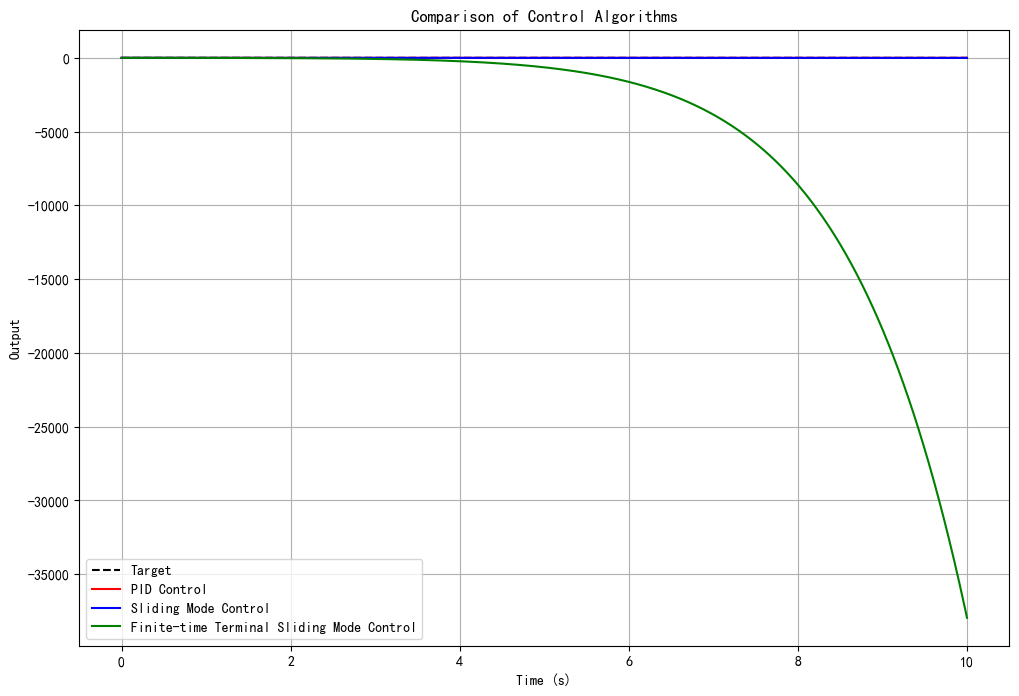